# Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
book = cv.imread('./book.pgm')

scene = cv.imread('./scene.pgm')

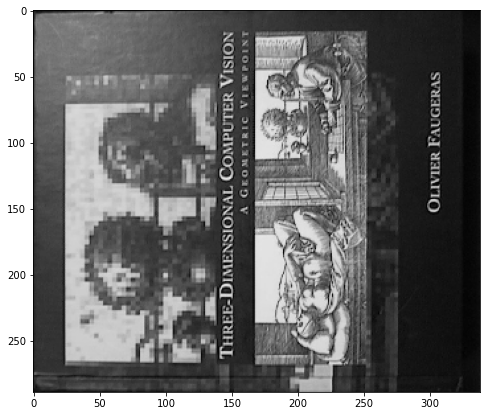

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(book)

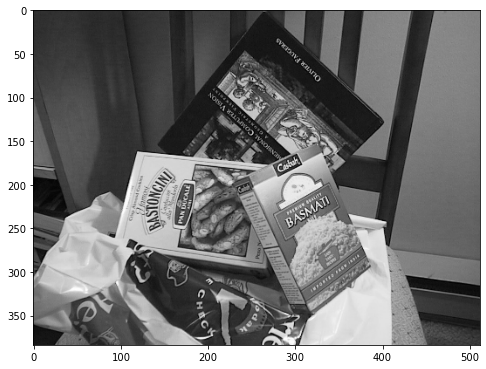

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(scene)

### SIFT Detector

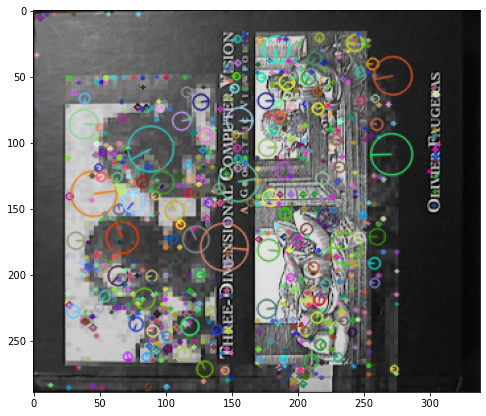

In [5]:
sift = cv.SIFT_create()

book_kp, book_des = sift.detectAndCompute(book, None)
scene_kp, scene_des = sift.detectAndCompute(scene, None)

book_draw = None
book_draw = cv.drawKeypoints(book,book_kp,book_draw,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('book_kp.jpg',book_draw)

plt.figure(figsize=(8,8))
plt.imshow(book_draw)

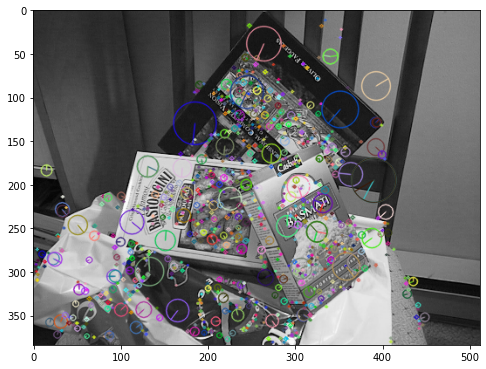

In [6]:
scene_draw = None
scene_draw = cv.drawKeypoints(scene,scene_kp,scene_draw,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('scene_kp.jpg',scene_draw)

plt.figure(figsize=(8,8))
plt.imshow(scene_draw)

### Find Closest Neighbors

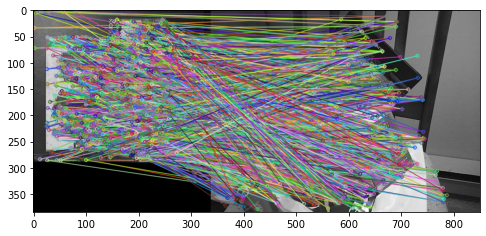

In [7]:
bf = cv.BFMatcher()
matches = bf.knnMatch(book_des, scene_des, k=2)

matched = None
matched = cv.drawMatchesKnn(book, book_kp, scene, scene_kp, matches, matched, flags= 2)
plt.figure(figsize=(8,8))
plt.imshow(matched)

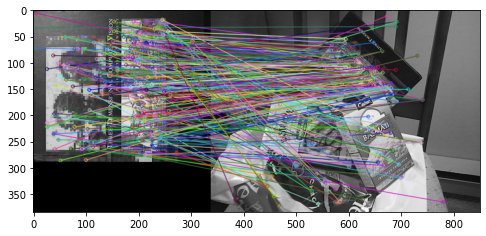

In [8]:
good = []
good_for_draw = []
for i,j in matches:
    if i.distance < 0.9 * j.distance:
        good_for_draw.append([i])
        good.append(i)

matched = cv.drawMatchesKnn(book, book_kp, scene, scene_kp, good_for_draw, None, flags= 2)
plt.figure(figsize=(8,8))
plt.imshow(matched)

In [9]:
src_pts = np.float32([book_kp[m.queryIdx].pt for m in good])
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good])

### RANSAC

In [10]:
N = 100

best_inlier_ct = 0
best_inlier_set = 0
best_q = 0

for i in range(N):
    picked = np.random.choice(range(len(src_pts)), 3)
    A = np.zeros([6,6])
    b = np.zeros([6])
    for j in range(3):
        idx = picked[j]
        A[2 * j][0] = src_pts[idx][0]
        A[2 * j][1] = src_pts[idx][1]
        A[2 * j][2] = 1
        A[2 * j + 1][3] = src_pts[idx][0]
        A[2 * j + 1][4] = src_pts[idx][1]
        A[2 * j + 1][5] = 1
        b[2 * j] = dst_pts[idx][0]
        b[2 * j + 1] = dst_pts[idx][1]
    try:
        q = np.linalg.solve(A, b)
    except:
        continue

    inlier_ct = 0
    inlier_set = []

    for k in range(len(src_pts)):
        homogeneous = np.array([[src_pts[k][0],src_pts[k][1],1,0,0,0],[0,0,0,src_pts[k][0],src_pts[k][1],1]])
        trans = np.dot(homogeneous,q)
        if np.linalg.norm(trans - dst_pts[k]) < 10:
            inlier_ct += 1
            inlier_set.append(good[k])
    if inlier_ct > best_inlier_ct:
        best_inlier_ct = inlier_ct
        best_inlier_set = inlier_set
        best_q = q

print(best_inlier_ct)

114


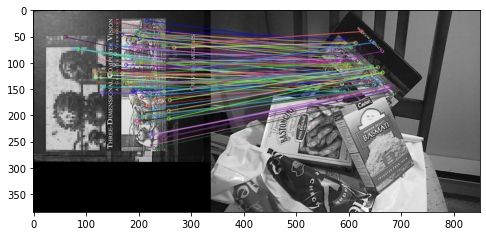

In [11]:
# refit
matched = cv.drawMatches(book, book_kp, scene, scene_kp, best_inlier_set, None, flags= 2)
plt.figure(figsize=(8,8))
plt.imshow(matched)

### Homography matrix

In [12]:
H = np.zeros([3,3])
H[0][0] = best_q[0]
H[0][1] = best_q[1]
H[0][2] = best_q[4]
H[1][0] = best_q[2]
H[1][1] = best_q[3]
H[1][2] = best_q[5]
H[2][0] = 0
H[2][1] = 0
H[2][2] = 1

print(H)

[[  0.39590584   0.45489114   0.40498919]
 [135.39650762  -0.43382446 153.60636324]
 [  0.           0.           1.        ]]


In [13]:
H = np.zeros([2,3])
H[0][0] = best_q[0]
H[0][1] = best_q[1]
H[0][2] = best_q[2]
H[1][0] = best_q[3]
H[1][1] = best_q[4]
H[1][2] = best_q[5]

print(H)

[[  0.39590584   0.45489114 135.39650762]
 [ -0.43382446   0.40498919 153.60636324]]


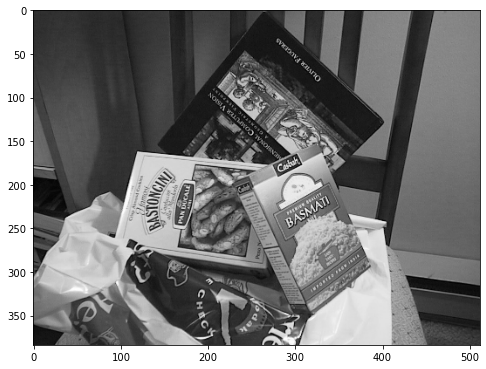

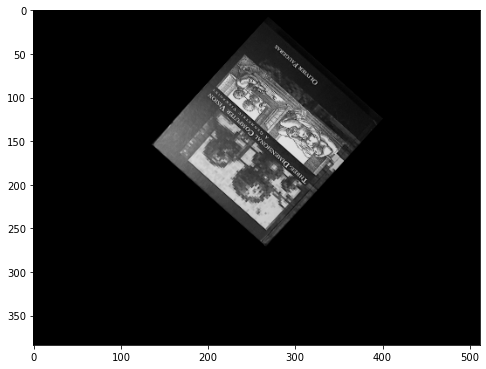

In [14]:
aligned = cv.warpAffine(book, H, (scene.shape[1],scene.shape[0]))

plt.figure(figsize=(8,8))
plt.imshow(scene)

plt.figure(figsize=(8,8))
plt.imshow(aligned)

# Part 2

In [15]:
import numpy as np
from scipy import linalg
from scipy.spatial.distance import cdist

## Part A

In [16]:
image = np.loadtxt('./image.txt')
world = np.loadtxt('./world.txt')

In [17]:
img_ones = np.ones((1,image.shape[1]))
img_vector = np.concatenate((image, img_ones))
wld_ones = np.ones((1,world.shape[1]))
wld_vector = np.concatenate((world,wld_ones))

### Construct Matirx A

In [18]:
A = np.zeros([20,12])
for i in range(image.shape[1]):
    A[i][4:8] = -wld_vector[:,i] * img_vector[2][i]
    A[i][8:12] = wld_vector[:,i] * img_vector[1][i]
    A[i + 10][0:4] = wld_vector[:,i] * img_vector[2][i]
    A[i + 10][8:12] = wld_vector[:,i] * img_vector[0][i]

### Construct Matrix P

In [19]:
U, S, V = np.linalg.svd(A)
P = V[-1:].reshape(3,4)
print(P)

[[ 1.27000127e-01  2.54000254e-01  3.81000381e-01  5.08000508e-01]
 [-5.08000508e-01 -3.81000381e-01 -2.54000254e-01 -1.27000127e-01]
 [-1.27000127e-01 -2.84587182e-16 -1.27000127e-01  2.01339041e-16]]


### Reconstruct points and project

In [20]:
reproj = np.dot(P, wld_vector)
reproj = reproj / reproj[-1]
print(reproj)

[[ -5.11770701  -5.5236545   -7.16310171  -5.22216628  -5.60479614
  -13.59494885  -8.73452189  -6.22433952  -9.74763886  -5.09031079]
 [  4.76538441   3.87032917   7.35942066   4.4279585    4.67483648
   10.05215495   5.56420531   3.90821885   6.90423723   4.5508513 ]
 [  1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.        ]]


In [21]:
print(img_vector)

[[ 5.11770701  5.5236545   7.16310171  5.22216628  5.60479614 13.59494885
   8.73452189  6.22433952  9.74763886  5.09031079]
 [ 4.76538441  3.87032917  7.35942066  4.4279585   4.67483648 10.05215495
   5.56420531  3.90821885  6.90423723  4.5508513 ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]]


In [22]:
dist = cdist(img_vector, reproj)
print(dist)

[[4.84760191e+01 6.38235130e+00 2.12940070e+01]
 [4.28038161e+01 1.36010250e-14 1.57103228e+01]
 [2.72310022e+01 1.57103228e+01 0.00000000e+00]]


## Part B

### Find C using SVD

In [23]:
U, S, V = np.linalg.svd(P)
C = V[-1]
C = C[:-1]/C[-1]
print(C)

[ 1. -1. -1.]


### Find C using RQ Decomposition

In [24]:
R, Q = linalg.rq(P, mode='economic')
R = (Q.T)[:-1].T
print(R.shape)
t = (Q.T)[-1].T
print(t.shape)
C_2 = np.linalg.solve(-R, t)
print(C_2)

(3, 3)
(3,)
[ 1. -1. -1.]


# Part 3

In [25]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import scipy.io as sio
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

## Load points

In [26]:
matrix = sio.loadmat('./sfm_points.mat')['image_points']
matrix.shape

(2, 600, 10)

## Copute translation vector

In [27]:
# centroid of point in each image
centroid = np.zeros((2,1))
# loop through each image
for i in range(10):
    image_i_points = matrix[:,:,i]
    num_points = image_i_points.shape[1]
    x_avg = np.sum(image_i_points[0,:]) / num_points
    y_avg = np.sum(image_i_points[1,:]) / num_points
    avg_points = np.array([x_avg, y_avg])
    centroid = np.append(centroid, avg_points.reshape(-1, 1), axis=1)
centroid = centroid[:,1:]

# print translation vector for first camera
print(centroid[:,0])

[2.36847579e-17 8.28966525e-17]


In [28]:
centered_matrix = np.zeros(matrix.shape)
for i in range(centered_matrix.shape[0]):
    for j in range(centered_matrix.shape[2]):
        centered_matrix[i,:,j] = matrix[i,:,j] - centroid[i][j]

## Construct measurement matrix W

In [29]:
W = np.zeros([2 * matrix.shape[2], matrix.shape[1]])
# for each point i
for i in range(matrix.shape[1]):
    # for each image j
    for j in range(matrix.shape[2]):
        W[2 * j, i] = centered_matrix[0, i, j]
        W[2 * j + 1, i] = centered_matrix[1, i, j]

## SVD of W

In [30]:
U, D, V = np.linalg.svd(W)
V_T = V.T
# D should only have values on diagonal so convert D to diagonal matrix
D = D * np.identity(D.shape[0])

## Find camera locations M

In [31]:
M = np.dot(U[:,:3], D[:3,:3])
# print first camera location
print(M[:2])

[[-7.50914219  3.30837904 -3.71763726]
 [-4.53754376 -1.57773527  7.74574759]]


## 3d World Points

In [32]:
world_points_3d = V_T[:,:3]

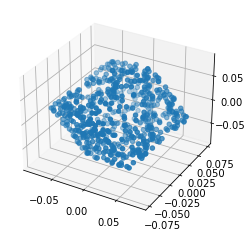

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(world_points_3d[:,0], world_points_3d[:,1], world_points_3d[:,2])
plt.show()

In [34]:
# print first 10 world points
print(world_points_3d[:10])

[[ 0.00577163  0.06460628 -0.02497615]
 [ 0.0005761   0.06885363 -0.03458151]
 [-0.04293585  0.06330479  0.02861711]
 [ 0.04745038  0.04904207 -0.01257547]
 [-0.04210186  0.06789239  0.01175164]
 [ 0.05961964  0.0460518  -0.01438374]
 [ 0.00909167  0.06002049 -0.01229997]
 [ 0.01039489  0.04602065  0.03529275]
 [-0.02589081  0.05702972  0.03337375]
 [ 0.01745598  0.04054264  0.04731859]]
